# Exploratory Text Analysis






The exploration and analysis of the text will be focused on inspecting the main features of the DSTC2 dataset. This dataset provides dialogues of a human talking to a information system labelled with slots and dialogue actions. In our case, we are going to focus on the user utterances.

## Required libraries

In [ ]:
# To install on Colab
!pip install deeppavlov

In [ ]:
# Deeppavlov
from deeppavlov.dataset_readers.dstc2_reader import DSTC2DatasetReader
from deeppavlov.dataset_iterators.dstc2_intents_iterator import Dstc2IntentsDatasetIterator

# Keras
from tensorflow.keras.preprocessing.text import Tokenizer

# NumPy
import numpy as np

# NLTK
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet

# Matplotlib
import matplotlib.pyplot as plt

# WordCloud
from wordcloud import WordCloud, STOPWORDS

# Standard
import pickle

## Paths

In [ ]:
dataset_path = "/content/drive/My Drive/_TFM/Notebooks/Datasets/"

# Download some tools for the NLTK library
nltk.download("wordnet")
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

## Data reading


### Prepare datasets

We download the labelled dialogues from Dialog State Tracking Challenge 2 ([DSTC2](http://camdial.org/~mh521/dstc/)) into the `data` variable.

In [ ]:
data = DSTC2DatasetReader().read(dataset_path)

2020-06-05 17:36:13.829 INFO in 'deeppavlov.dataset_readers.dstc2_reader'['dstc2_reader'] at line 112: [loading dialogs from /content/drive/My Drive/_TFM/Notebooks/Datasets/dstc2-trn.jsonlist]
2020-06-05 17:36:14.418 INFO in 'deeppavlov.dataset_readers.dstc2_reader'['dstc2_reader'] at line 112: [loading dialogs from /content/drive/My Drive/_TFM/Notebooks/Datasets/dstc2-val.jsonlist]
2020-06-05 17:36:14.902 INFO in 'deeppavlov.dataset_readers.dstc2_reader'['dstc2_reader'] at line 112: [loading dialogs from /content/drive/My Drive/_TFM/Notebooks/Datasets/dstc2-tst.jsonlist]


We inspect one dialogue between one user (speaker 1) and the system (speaker 2).

In [ ]:
!head -n 14 "$dataset_path"dstc2-trn.jsonlist

{"speaker": 2, "text": "Hello, welcome to the Cambridge restaurant system. You can ask for restaurants by area, price range or food type. How may I help you?", "dialog_acts": [{"act": "welcomemsg", "slots": []}]}
{"speaker": 1, "text": "cheap restaurant", "goals": {"pricerange": "cheap"}, "dialog_acts": [{"slots": [["pricerange", "cheap"]], "act": "inform"}]}
{"speaker": 2, "text": "What kind of food would you like?", "dialog_acts": [{"act": "request_food", "slots": []}]}
{"speaker": 1, "text": "any", "goals": {"food": "dontcare", "pricerange": "cheap"}, "dialog_acts": [{"slots": [["this", "dontcare"]], "act": "inform"}]}
{"speaker": 2, "text": "What part of town do you have in mind?", "dialog_acts": [{"act": "request_area", "slots": []}]}
{"speaker": 1, "text": "south", "goals": {"food": "dontcare", "pricerange": "cheap", "area": "south"}, "dialog_acts": [{"slots": [["area", "south"]], "act": "inform"}]}
{"speaker": 2, "text": "api_call area=\"south\" food=\"dontcare\" pricerange=\"ch

DSTC2 dataset does not contain information about user intents which will be our labels, therefore, we build artificial intents for each user utterance using information from dialogue acts and slots.

In [ ]:
iterator = Dstc2IntentsDatasetIterator(data)

Inspect the original raw texts in JSON format.


In [ ]:
# Raw text of the system turn
iterator.train[0]

({'episode_done': True, 'intents': [], 'text': ''},
 {'act': 'welcomemsg',
  'text': 'Hello, welcome to the Cambridge restaurant system. You can ask for restaurants by area, price range or food type. How may I help you?'})

In [ ]:
# Raw text of the user turn
iterator.train[1]

({'intents': [{'act': 'inform', 'slots': [['pricerange', 'cheap']]}],
  'text': 'cheap restaurant'},
 {'act': 'request_food', 'text': 'What kind of food would you like?'})

And the intent for this user turn is

In [ ]:
iterator.data["train"][0][1]

['inform_pricerange']

So, our data will be like the next samples:

In [ ]:
iterator.data["train"][0:10]

[('cheap restaurant', ['inform_pricerange']),
 ('any', ['inform_this']),
 ('south', ['inform_area']),
 ('south', ['inform_area']),
 ('address', ['request_addr']),
 ('phone number', ['request_phone']),
 ('thank you good bye', ['thankyou', 'bye']),
 ('gastropub', ['inform_food']),
 ('gastropub', ['inform_food']),
 ('gastropub', ['inform_food'])]

As we can observe, we only focus on the user utterances.

### Save datasets

**Read instances**

In [ ]:
# Train
x_train = list(iterator.get_instances(data_type="train")[0])
y_train = list(iterator.get_instances(data_type="train")[1])

# Validation
x_valid = list(iterator.get_instances(data_type="valid")[0])
y_valid = list(iterator.get_instances(data_type="valid")[1])

# Test
x_test = list(iterator.get_instances(data_type="test")[0])
y_test = list(iterator.get_instances(data_type="test")[1])

**Check data**

In [ ]:
print("Data = (X: user utterances, y: intents)")

print("\n  > Train data:")
print("Samples: 8148 = %s" % len(x_train))
print(list(zip(x_train, y_train))[:3])

print("\n  > Validation data:")
print("Samples: 5656 = %s" % len(x_valid))
print(list(zip(x_valid, y_valid))[:3])

print("\n  > Test data:")
print("Samples: 5769 = %s" % len(x_test))
print(list(zip(x_test, y_test))[:3])

Data = (X: user utterances, y: intents)

  > Train data:
Samples: 8148 = 8148
[('cheap restaurant', ['inform_pricerange']), ('any', ['inform_this']), ('south', ['inform_area'])]

  > Validation data:
Samples: 5656 = 5656
[('sil', ['unknown']), ('north part of town serving gastropub food', ['inform_food', 'inform_area']), ('north part of town serving gastropub food', ['inform_food', 'inform_area'])]

  > Test data:
Samples: 5769 = 5769
[('uh yes im looking for a cheap restaurant in the west part of town', ['affirm', 'inform_pricerange', 'inform_area']), ('west', ['inform_area']), ('uh yes a cheap restaurant', ['affirm', 'inform_pricerange'])]


**Save data**

In [ ]:
# x_train
x_train_obj = open(dataset_path + "x_train.obj", "wb")
pickle.dump(x_train, x_train_obj)
x_train_obj.close()

# y_train
y_train_obj = open(dataset_path + "y_train.obj", "wb")
pickle.dump(y_train, y_train_obj)
y_train_obj.close()


# x_valid
x_valid_obj = open(dataset_path + "x_valid.obj", "wb")
pickle.dump(x_valid, x_valid_obj)
x_valid_obj.close()

# y_valid
y_valid_obj = open(dataset_path + "y_valid.obj", "wb")
pickle.dump(y_valid, y_valid_obj)
y_valid_obj.close()


# x_test
x_test_obj = open(dataset_path + "x_test.obj", "wb")
pickle.dump(x_test, x_test_obj)
x_test_obj.close()

# y_test
y_test_obj = open(dataset_path + "y_test.obj", "wb")
pickle.dump(y_test, y_test_obj)
y_test_obj.close()

### Load datasets

In [ ]:
# x_train
x_train_obj = open(dataset_path + "x_train.obj", "rb")
x_train = pickle.load(x_train_obj)
x_train_obj.close()

# y_train
y_train_obj = open(dataset_path + "y_train.obj", "rb")
y_train = pickle.load(y_train_obj)
y_train_obj.close()

# x_valid
x_valid_obj = open(dataset_path + "x_valid.obj", "rb")
x_valid = pickle.load(x_valid_obj)
x_valid_obj.close()

# y_valid
y_valid_obj = open(dataset_path + "y_valid.obj", "rb")
y_valid = pickle.load(y_valid_obj)
y_valid_obj.close()

# x_test
x_test_obj = open(dataset_path + "x_test.obj", "rb")
x_test = pickle.load(x_test_obj)
x_test_obj.close()

# y_test
y_test_obj = open(dataset_path + "y_test.obj", "rb")
y_test = pickle.load(y_test_obj)
y_test_obj.close()

**Check data**

In [ ]:
print("Data = (X: user utterances, y: intents)")

print("\n  > Train data:")
print("Samples: 8148 = %s" % len(x_train))
print(list(zip(x_train, y_train))[:3])

print("\n  > Validation data:")
print("Samples: 5656 = %s" % len(x_valid))
print(list(zip(x_valid, y_valid))[:3])

print("\n  > Test data:")
print("Samples: 5769 = %s" % len(x_test))
print(list(zip(x_test, y_test))[:3])

Data = (X: user utterances, y: intents)

  > Train data:
Samples: 8148 = 8148
[('cheap restaurant', ['inform_pricerange']), ('any', ['inform_this']), ('south', ['inform_area'])]

  > Validation data:
Samples: 5656 = 5656
[('sil', ['unknown']), ('north part of town serving gastropub food', ['inform_food', 'inform_area']), ('north part of town serving gastropub food', ['inform_food', 'inform_area'])]

  > Test data:
Samples: 5769 = 5769
[('uh yes im looking for a cheap restaurant in the west part of town', ['affirm', 'inform_pricerange', 'inform_area']), ('west', ['inform_area']), ('uh yes a cheap restaurant', ['affirm', 'inform_pricerange'])]


In [ ]:
list(zip(x_train, y_train))[:10]

[('cheap restaurant', ['inform_pricerange']),
 ('any', ['inform_this']),
 ('south', ['inform_area']),
 ('south', ['inform_area']),
 ('address', ['request_addr']),
 ('phone number', ['request_phone']),
 ('thank you good bye', ['thankyou', 'bye']),
 ('gastropub', ['inform_food']),
 ('gastropub', ['inform_food']),
 ('gastropub', ['inform_food'])]

In [ ]:
list(zip(x_valid, y_valid))[:10]

[('sil', ['unknown']),
 ('north part of town serving gastropub food', ['inform_food', 'inform_area']),
 ('north part of town serving gastropub food', ['inform_food', 'inform_area']),
 ('what about a chinese restaurant in the north of town',
  ['inform_food', 'inform_area']),
 ('what about a chinese restaurant in the north of town',
  ['inform_food', 'inform_area']),
 ('do they serve chinese food', ['confirm_food']),
 ('just chinese food in the north part of town',
  ['inform_food', 'inform_area']),
 ('i dont care', ['inform_this']),
 ('i dont care', ['inform_this']),
 ('what is their phone number', ['request_phone'])]

In [ ]:
list(zip(x_test, y_test))[:10]

[('uh yes im looking for a cheap restaurant in the west part of town',
  ['affirm', 'inform_pricerange', 'inform_area']),
 ('west', ['inform_area']),
 ('uh yes a cheap restaurant', ['affirm', 'inform_pricerange']),
 ('uh it doesnt matter', ['inform_this']),
 ('uh it doesnt matter', ['inform_this']),
 ('okay and uh whats their phone number please', ['request_phone']),
 ('okay and um thank you and good bye', ['bye']),
 ('im looking for a restaurant in the west part of town serving italian food',
  ['inform_food', 'inform_area']),
 ('doesnt matter', ['inform_this']),
 ('i dont care', ['inform_this'])]

## Data exploration

In [ ]:
x_data = np.concatenate([x_train, x_valid, x_test])
y_data = np.concatenate([y_train, y_valid, y_test])

Number of samples in the datasets:

In [ ]:
print("Number of samples in the train dataset = %s" % len(x_train))
print("Number of samples in the validation dataset = %s" % len(x_valid))
print("Number of samples in the test dataset = %s" % len(x_test))

Number of samples in the train dataset = 8148
Number of samples in the validation dataset = 5656
Number of samples in the test dataset = 5769


### User utterances

Length and mean value of the number of words in the user utterances:

In [ ]:
max_words_sample = max([len(sample.split()) for sample in x_data])
min_words_sample = min([len(sample.split()) for sample in x_data])
mean_words_sample = np.mean([len(sample.split()) for sample in x_data])

In [ ]:
print("The sample with the maximum number of words has %s words" % max_words_sample)
print("The sample with the minimum number of words has %s words" % min_words_sample)
print("The mean number of words in the sample is %s words" % round(mean_words_sample, 2))

The sample with the maximum number of words has 22 words
The sample with the minimum number of words has 1 words
The mean number of words in the sample is 3.82 words


Relative frequency of the number of words in the sample:

In [ ]:
num_words_sample = [len(sample.split()) for sample in x_data]

num_words, rel_freq = np.unique(num_words_sample, return_counts=True)
dict(zip(num_words, rel_freq))

{1: 4765,
 2: 3598,
 3: 2125,
 4: 4053,
 5: 1358,
 6: 776,
 7: 588,
 8: 462,
 9: 420,
 10: 300,
 11: 312,
 12: 333,
 13: 211,
 14: 103,
 15: 93,
 16: 48,
 17: 14,
 18: 10,
 19: 1,
 21: 2,
 22: 1}

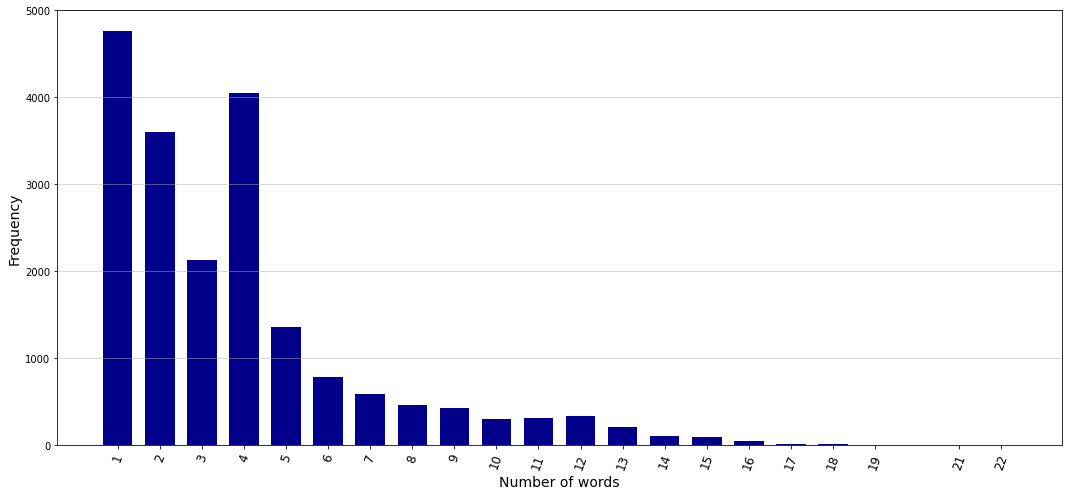

In [ ]:
plt.figure(figsize=(18, 8))
plt.bar(num_words, rel_freq, width = 0.7, color="darkblue")
plt.xticks(num_words, rotation=70, fontsize=12)
plt.grid(axis="y", alpha=0.6)
plt.ylabel("Frequency", fontsize=14)
plt.xlabel("Number of words", fontsize=14)

plt.show()

Absolute frequency of the number of words in the sample:

In [ ]:
dict(zip(num_words, rel_freq/len(num_words_sample)))

{1: 0.2434476063965667,
 2: 0.18382465641444848,
 3: 0.10856792520308588,
 4: 0.20707096510499157,
 5: 0.06938129055331324,
 6: 0.03964645174475042,
 7: 0.030041383538548,
 8: 0.023603944208859143,
 9: 0.021458131098962857,
 10: 0.015327236499259184,
 11: 0.01594032595922955,
 12: 0.017013232514177693,
 13: 0.010780156337812293,
 14: 0.0052623511980789866,
 15: 0.004751443314770347,
 16: 0.0024523578398814696,
 17: 0.0007152710366320952,
 18: 0.0005109078833086395,
 19: 5.109078833086395e-05,
 21: 0.0001021815766617279,
 22: 5.109078833086395e-05}

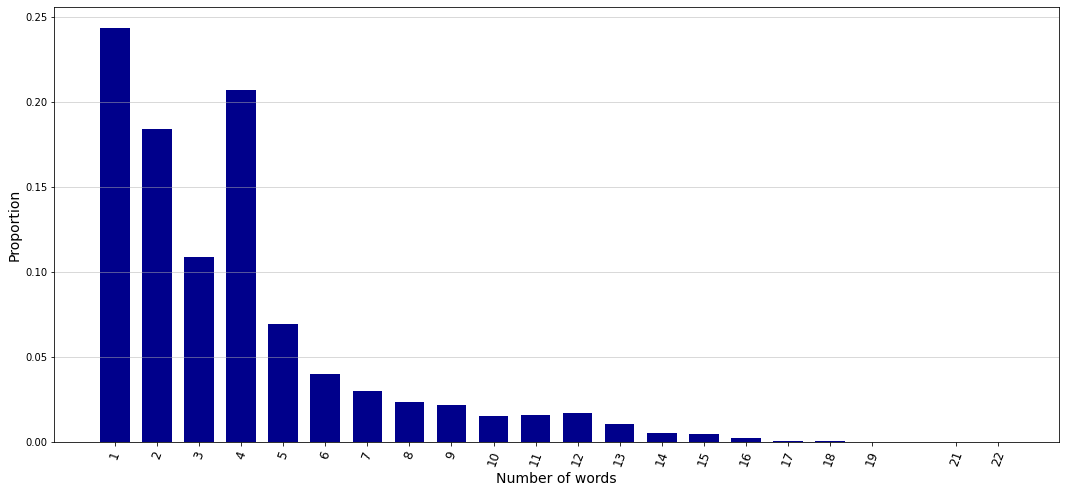

In [ ]:
plt.figure(figsize=(18, 8))
plt.bar(num_words, rel_freq/len(num_words_sample), width = 0.7, color="darkblue")
plt.xticks(num_words, rotation=70, fontsize=12)
plt.grid(axis="y", alpha=0.6)
plt.ylabel("Proportion", fontsize=14)
plt.xlabel("Number of words", fontsize=14)

plt.show()

WordCloud representation of the most used words in each user utterances:

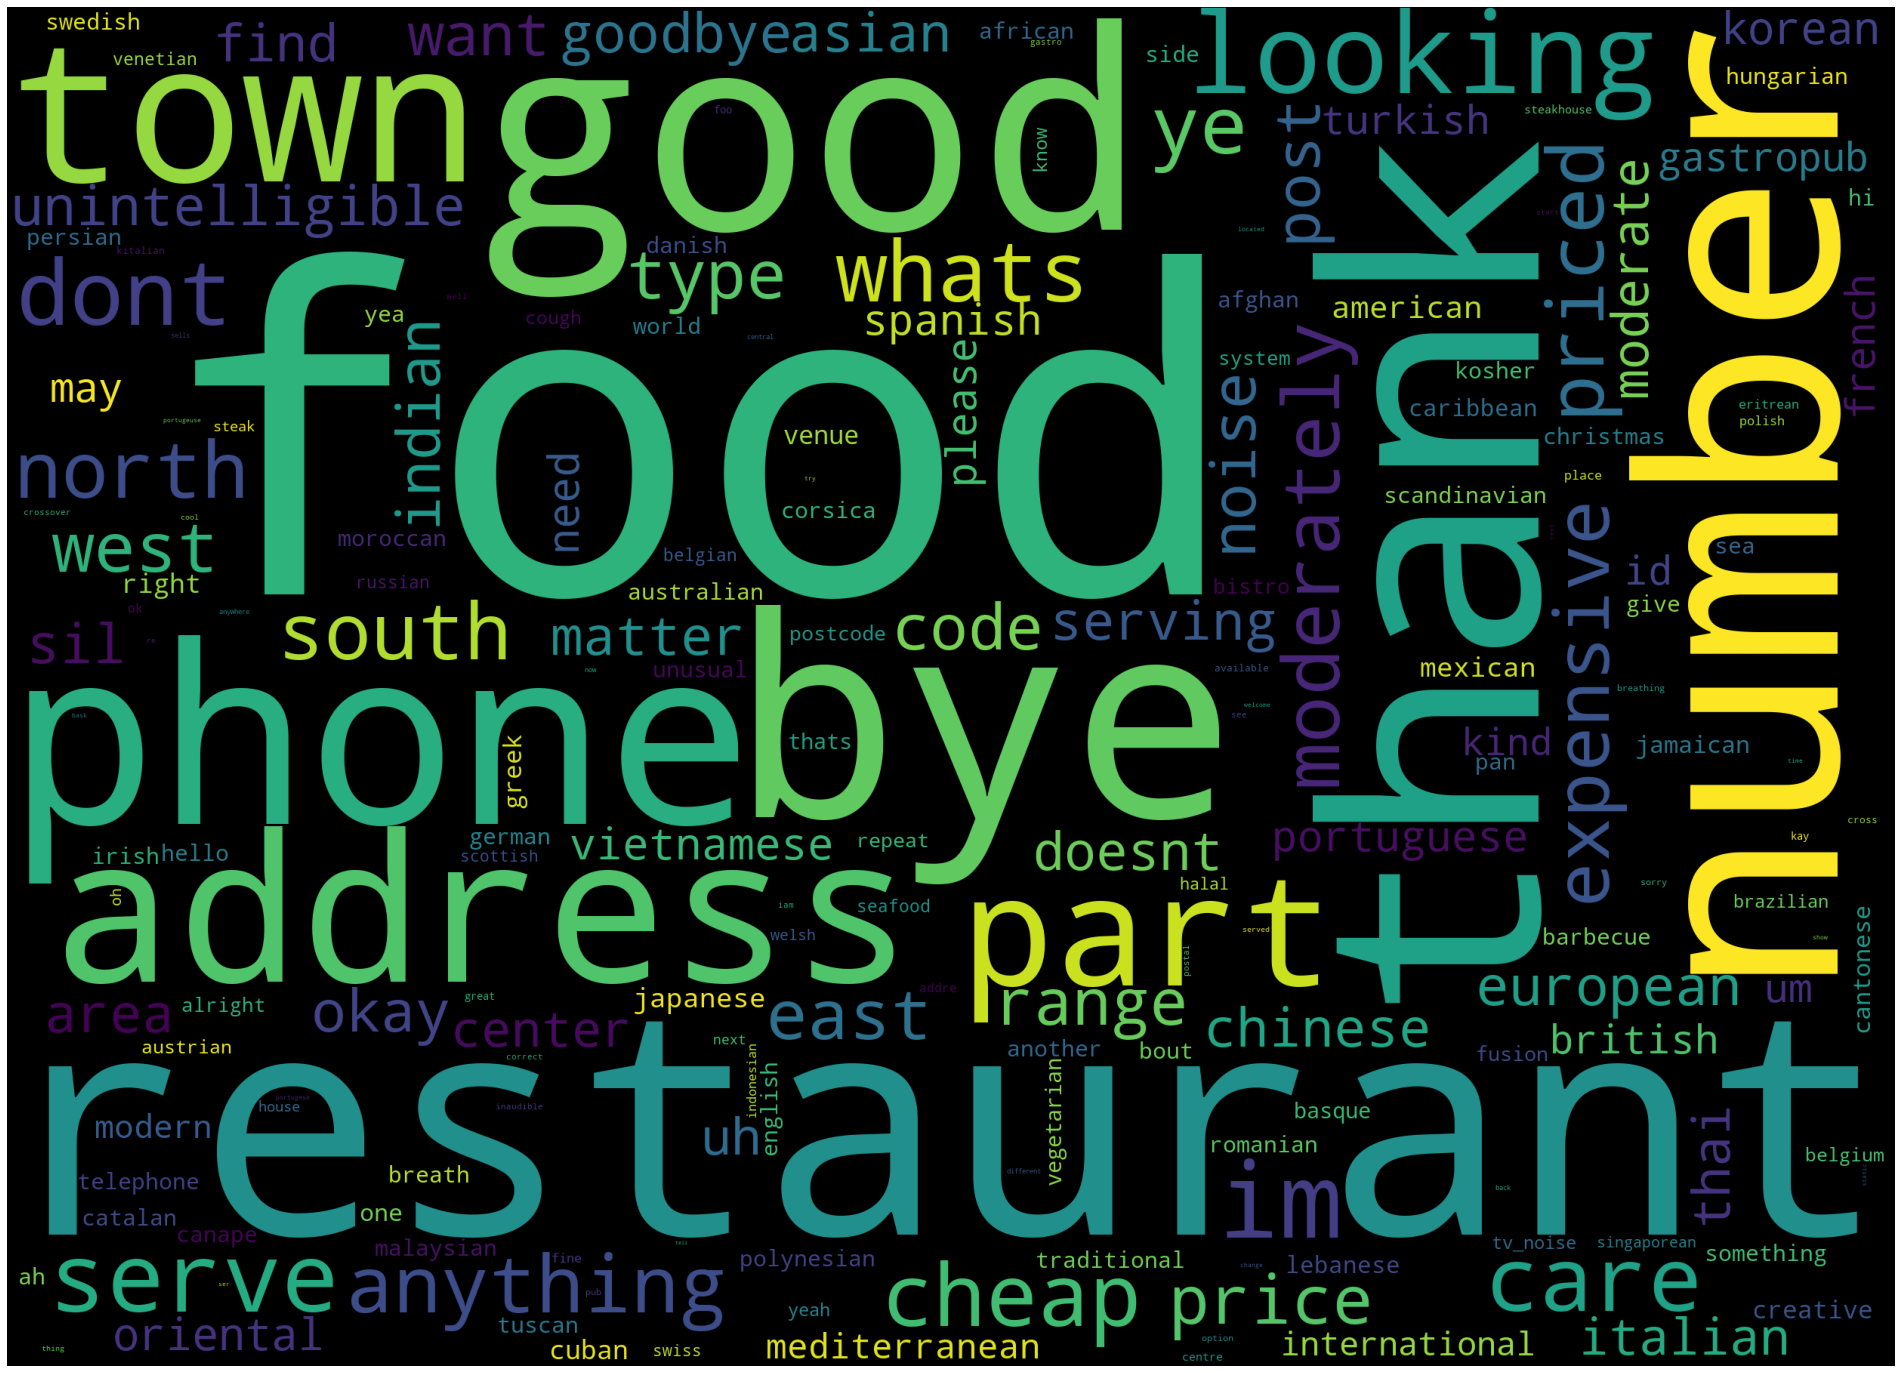

In [ ]:
plt.figure(figsize=(40,25))

text = x_data

wc = WordCloud(stopwords=STOPWORDS,
               background_color='black',
               collocations=False,
               width=2500,
               height=1800
               ).generate(" ".join(text))

plt.axis('off')
plt.imshow(wc)

### Labels

We get out our labels:

In [ ]:
labels = list()

for sample in y_data:
  for label in sample:
    if label in labels:
      continue
    else:
      labels.append(label)

In [ ]:
print("There are %s labels." % len(labels))

There are 29 labels.


In [ ]:
print("The labels are: %s" % labels)

The labels are: ['inform_pricerange', 'inform_this', 'inform_area', 'request_addr', 'request_phone', 'thankyou', 'bye', 'inform_food', 'unknown', 'confirm_pricerange', 'confirm_food', 'negate', 'affirm', 'reqalts', 'request_area', 'request_pricerange', 'request_postcode', 'inform_name', 'request_food', 'confirm_area', 'hello', 'repeat', 'ack', 'deny_name', 'restart', 'deny_food', 'reqmore', 'request_signature', 'request_name']


**Save**

In [ ]:
labels_obj = open(dataset_path + "labels.obj", "wb")
pickle.dump(labels, labels_obj)
labels_obj.close()

**Load**

In [ ]:
labels_obj = open(dataset_path + "labels.obj", "rb")
labels = pickle.load(labels_obj)
labels_obj.close()

# Check it
print("We expect 29 labels and there are %s labels." % len(labels))

We expect 29 labels and there are 29 labels.


Labels per user utterance:

In [ ]:
max_len_labels = max([len(label) for label in y_data])
min_len_labels = min([len(label) for label in y_data])

In [ ]:
print("Max labels per user utterance = %s" % max_len_labels)
print("Min labels per user utterance = %s" % min_len_labels)

Max labels per user utterance = 3
Min labels per user utterance = 1


Number of user utterances in each label:

In [ ]:
labels_totals = list()

for sample in y_data:
  for label in sample:
      labels_totals.append(label)

In [ ]:
unique_label, count_label = np.unique(labels_totals, return_counts=True)
dict(zip(unique_label, count_label))

{'ack': 26,
 'affirm': 788,
 'bye': 2221,
 'confirm_area': 35,
 'confirm_food': 96,
 'confirm_pricerange': 36,
 'deny_food': 9,
 'deny_name': 5,
 'hello': 69,
 'inform_area': 2503,
 'inform_food': 5119,
 'inform_name': 24,
 'inform_pricerange': 2261,
 'inform_this': 1490,
 'negate': 221,
 'repeat': 33,
 'reqalts': 1715,
 'reqmore': 4,
 'request_addr': 1797,
 'request_area': 193,
 'request_food': 347,
 'request_name': 4,
 'request_phone': 1885,
 'request_postcode': 404,
 'request_pricerange': 299,
 'request_signature': 5,
 'restart': 8,
 'thankyou': 2162,
 'unknown': 1426}

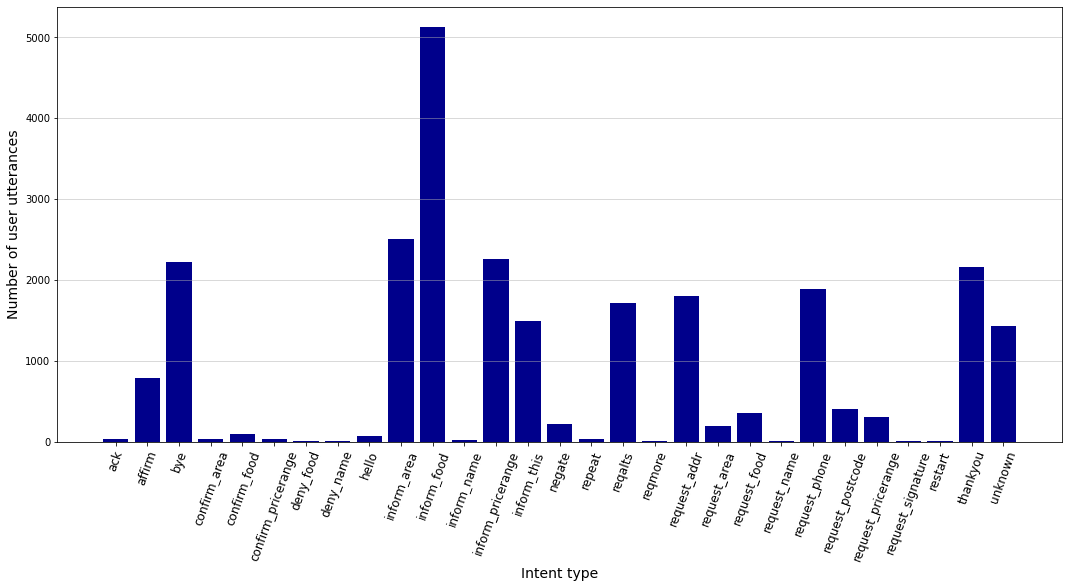

In [ ]:
plt.figure(figsize=(18, 8))
plt.bar(unique_label, count_label, width = 0.8, color="darkblue")
plt.xticks(rotation=70, fontsize=12)
plt.grid(axis="y", alpha=0.6)
plt.ylabel("Number of user utterances", fontsize=14)
plt.xlabel("Intent type", fontsize=14)

plt.show()

Number of user utterances which have multiple labels:

In [ ]:
labels_len = list()

for sample in y_data:
  labels_len.append(len(sample))

Relative frequency of the number of intents

In [ ]:
unique_label_len, count_label_len = np.unique(labels_len, return_counts=True)
dict(zip(unique_label_len, count_label_len))

{1: 14122, 2: 5290, 3: 161}

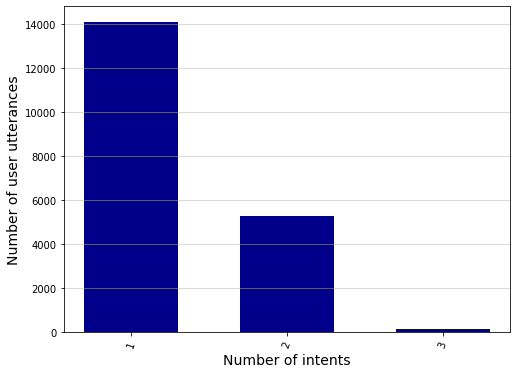

In [ ]:
plt.figure(figsize=(8, 6))
plt.bar(unique_label_len, count_label_len, width = 0.6, color="darkblue")
plt.xticks(unique_label_len, rotation=70)
plt.grid(axis="y", alpha=0.6)
plt.ylabel("Frequency", fontsize=14)
plt.xlabel("Number of intents", fontsize=14)

plt.show()

Absolute frequency of the number of intents

In [ ]:
dict(zip(unique_label_len, count_label_len/len(labels_len)))

{1: 0.7215041128084606, 2: 0.2702702702702703, 3: 0.008225616921269096}

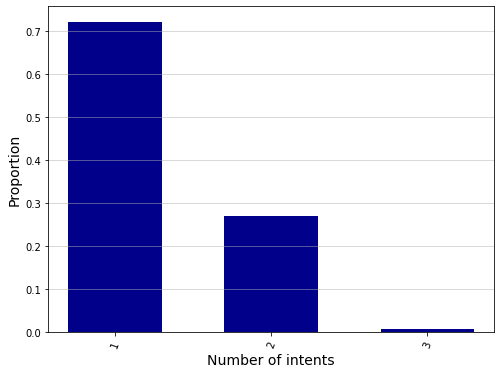

In [ ]:
plt.figure(figsize=(8, 6))
plt.bar(unique_label_len, count_label_len/len(labels_len), width = 0.6, color="darkblue")
plt.xticks(unique_label_len, rotation=70)
plt.grid(axis="y", alpha=0.6)
plt.ylabel("Proportion", fontsize=14)
plt.xlabel("Number of intents", fontsize=14)

plt.show()

## Dictionaries


We get out our vocabulary:

In [ ]:
# Decontract funtion
contracted_words_obj = open(dataset_path + "contracted_words.obj", "rb")
contracted_words = pickle.load(contracted_words_obj)
contracted_words_obj.close()

def decontract(text):
  for word in text.split():
    if word.lower() in contracted_words:
      text = text.replace(word, contracted_words[word.lower()])
  return text

# Normalize function
normalized_words_obj = open(dataset_path + "normalized_words.obj", "rb")
normalized_words = pickle.load(normalized_words_obj)
normalized_words_obj.close()

def normalize(text):
  for word in text.split():
    if word.lower() in normalized_words:
      text = text.replace(word, normalized_words[word.lower()])
  return text

In [ ]:
# Lemmatize function

# Set the lemmatizer
lemmatizer = WordNetLemmatizer()

# Get the POS tag for a given word
def get_pos_tag(word):
  tag = nltk.pos_tag([word])[0][1][0].upper()
  tag_dict = {"J": wordnet.ADJ,
              "N": wordnet.NOUN,
              "V": wordnet.VERB,
              "R": wordnet.ADV}
  return tag_dict.get(tag, wordnet.NOUN)

# Lemmatize a text with POS tag
def lemmatize(text, lemmatizer):
  word_list = nltk.word_tokenize(text)
  text_lemmatized = ' '.join([lemmatizer.lemmatize(word, get_pos_tag(word)) for word in word_list])
  return text_lemmatized

In [ ]:
# Decontract, normalize, lemmatize, lowercase and tokenize the text samples
tokenizer = Tokenizer(lower=True)
tokenizer.fit_on_texts(
    [lemmatize(normalize(decontract(sample)), lemmatizer) for sample in x_data])

# Vocabulary
x_vocab = tokenizer.word_index
x_vocab_size = len(x_vocab) + 1

In [ ]:
x_vocab_size

501

The vocabulary size has 501 unique words plus the unknown (unk) token.

### Contractions

**Dictionary**

In [ ]:
contracted_words = {
    "cant": "cannot",
    "couldve": "could have",
    "couldnt": "could not",
    "didnt": "did not",
    "doesnt": "does not",
    "dont": "do not",
    "hadnt": "had not",
    "hasnt": "has not",
    "havent": "have not",
    "hed": "he would",
    "hell": "he will",
    "hes": "he is",
    "howd": "how did",
    "howll": "how will",
    "hows": "how is",
    "iam": "i am",
    "im": "i am",
    "ive": "i have",
    "id": "i would",
    "isnt": "is not",
    "itd": "it would",
    "itll": "it will",
    "its": "it is",
    "lets": "let us",
    "maynt": "may not",
    "mightve": "might have",
    "mightnt": "might not",
    "mustve": "must have",
    "mustnt": "must not",
    "neednt": "need not",
    "oclock": "of the clock",
    "shed": "she would",
    "shell": "she will",
    "shes": "she is",
    "shouldve": "should have",
    "shouldnt": "should not",
    "thats": "that is",
    "thatll": "that will",
    "thered": "there would",
    "theres": "there is",
    "theyd": "they would",
    "theyll": "they will",
    "theyre": "they are",
    "theyve": "they have",
    "wasnt": "was not",
    "wed": "we would",
    "well": "we will",
    "were": "we are",
    "weve": "we have",
    "werent": "were not",
    "whatll": "what will",
    "whatre": "what are",
    "whats": "what is",
    "whatve": "what have",
    "whens": "when is",
    "whenve": "when have",
    "whered": "where did",
    "wheres": "where is",
    "whereve": "where have",
    "wholl": "who will",
    "whos": "who is",
    "whove": "who have",
    "whys": "why is",
    "whyve": "why have",
    "willve": "will have",
    "wont": "will not",
    "wouldve": "would have",
    "wouldnt": "would not",
    "youd": "you would",
    "youre": "you are",
    "youve": "you have"
}

**Save**

In [ ]:
contracted_words_obj = open(dataset_path + "contracted_words.obj", 'wb')
pickle.dump(contracted_words, contracted_words_obj)
contracted_words_obj.close()

**Load**

In [ ]:
contracted_words_obj = open(dataset_path + "contracted_words.obj", "rb")
contracted_words = pickle.load(contracted_words_obj)
contracted_words_obj.close()

### Normalizations

**Dictionary**

In [ ]:
normalized_words = {
    "vegitarian": "vegetarian",
    "worl": "world",
    "woulde": "would",
    "signapore": "singapore",
    "signaporean": "singaporean",
    "signaporian": "singaporean",
    "spani": "spanish",
    "spensive": "expensive",
    "sweedish": "swedish",
    "talian": "italian",
    "thare": "there",
    "turkiesh": "turkish",
    "uh": "oh",
    "umh": "um",
    "unintellgible": "unintelligible",
    "unitelligible": "unintelligible",
    "mediteranian": "mediterranean",
    "medetanian": "mediterranean",
    "mediteranean": "mediterranean",
    "meditteranian": "mediterranean",
    "medterranean": "mediterranean",
    "moroccon": "moroccan",
    "noice": "noise",
    "nosie": "noise",
    "nubmer": "number",
    "numeber": "number",
    "nymber": "number",
    "ooh": "oh",
    "opean": "open",
    "priced": "price",
    "rerestaurant": "restaurant",
    "resataurant": "restaurant",
    "restaraunt": "restaurant",
    "restaruant": "restaurant",
    "restauarant": "restaurant",
    "restauran": "restaurant",
    "restaurants": "restaurant",
    "restaurnt": "restaurant",
    "restuarant": "restaurant",
    "scandanavian": "scandinavian",
    "scandin": "scandinavian",
    "serf": "serve",
    "serv": "serve",
    "serves": "serve",
    "malaysian": "malaysian",
    "malyasian": "malaysian",
    "lcoated": "located",
    "jamcian": "jamaican",
    "katalian": "italian",
    "kitalian": "italian",
    "ad": "add",
    "adddress": "address",
    "addre": "address",
    "adress": "address",
    "addrss": "address",
    "bristish": "british",
    "carraibean": "caribbean",
    "canope": "canape",
    "canopy": "canape",
    "catalen": "catalan",
    "catalin": "catalan",
    "cantonates": "cantonese",
    "chineese": "chinese",
    "deosnt": "does not",
    "ecuadorean": "ecuadorian",
    "earatree": "eritrea",
    "earetree": "eritrea",
    "earatrain": "eritrean",
    "eartrain": "eritrean",
    "eirtrean": "eritrean",
    "airatarin": "eritrean",
    "airitran": "eritrean",
    "arotrian": "eritrean",
    "ele": "else",
    "elses": "else",
    "europ": "euro",
    "europone": "european",
    "euorpean": "european",
    "europene": "european",
    "expe": "expend",
    "expen": "expend",
    "fdod": "food",
    "ffood": "food",
    "foo": "food",
    "goodb": "goodbye",
    "itailian": "italian",
    "ital": "italy",
    "hutt": "hut",
    "moderat": "moderate",
    "modereate": "moderate",
    "modertley": "moderately",
    "modreately": "moderately",
    "portugeuse": "portuguese",
    "portugese": "portuguese",
    "ya": "yeah",
    "ye": "yeah",
    "yea": "yeah"
}

**Save**

In [ ]:
normalized_words_obj = open(dataset_path + "normalized_words.obj", 'wb')
pickle.dump(normalized_words, normalized_words_obj)
normalized_words_obj.close()

**Load**

In [ ]:
normalized_words_obj = open(dataset_path + "normalized_words.obj", "rb")
normalized_words = pickle.load(normalized_words_obj)
normalized_words_obj.close()